In [1]:
import numpy as np
import pandas as pd
from pandas.tools.plotting import table
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [2]:
from timeseries_functions import index_to_datetime, plot_all_df_columns, plot_series,\
plot_series_save_fig, plot_series_and_differences, run_augmented_Dickey_Fuller_test, \
plot_autocorrelation, plot_partial_autocorrelation, plot_decomposition

In [3]:
from timeseries_functions import make_col_vector, make_design_matrix, fit_linear_trend,\
plot_trend_data, plot_linear_trend

In [4]:
from fbprophet import Prophet

In [5]:
from prophet_functions import get_prophet_training_mse, get_prophet_test_mse,\
get_prophet_forecast, plot_prophet_forecast, get_prophet_forecast_w_holidays,\
prophet_forecast_to_csv

#### add holiday component

In [6]:
christmas_dates = ['2015-12-25', '2016-12-25', '2017-12-25']
new_year_dates = ['2016-01-01', '2017-01-01', '2018-01-01']
thanksgiving_dates = ['2015-11-26', '2016-11-24', '2017-11-23']

In [7]:
christmas = pd.DataFrame({'holiday':'Christams', 'ds': pd.to_datetime(christmas_dates)})

In [8]:
thanksgiving = pd.DataFrame({'holiday':'Thanksgiving', 'ds': pd.to_datetime(thanksgiving_dates)})

In [9]:
new_years = pd.DataFrame({'holiday':'New Years', 'ds': pd.to_datetime(new_year_dates)})

In [10]:
holidays = pd.concat([christmas, thanksgiving, new_years])

In [11]:
holidays1 = holidays.copy()
holidays2 = holidays.copy()
holidays1_2 = holidays.copy()
holidays2_1 = holidays.copy()

In [12]:
holidays1['lower_window'] = -1
holidays1['upper_window'] = 1

In [13]:
holidays2['lower_window'] = -2
holidays2['upper_window'] = 2

In [14]:
holidays1_2['lower_window'] = -1
holidays1_2['upper_window'] = 2

In [15]:
holidays2_1['lower_window'] = -2
holidays2_1['upper_window'] = 1

In [16]:
holiday_windows = [holidays1, holidays2, holidays1_2, holidays2_1]

### using weekly data

In [17]:
dr_df = pd.read_csv('./data/doctors_hours_per_provider.csv')
RNPA_df = pd.read_csv('./data/RNPA_hours_per_provider.csv')
ther_df = pd.read_csv('./data/therapists_hours_per_provider.csv')

In [18]:
dr_df

,AppointmentDate,Number_Providers,Hours,Hours_per_Provider
0,2015-01-12,4.0,84.250000,21.062500
1,2015-01-19,3.0,91.250000,30.416667
2,2015-01-26,3.0,82.000000,27.333333
3,2015-02-02,3.0,72.250000,24.083333
4,2015-02-09,5.0,97.250000,19.450000
5,2015-02-16,4.0,95.250000,23.812500
6,2015-02-23,4.0,79.250000,19.812500
7,2015-03-02,4.0,109.500000,27.375000
8,2015-03-09,5.0,71.000000,14.200000
9,2015-03-16,4.0,128.000000,32.000000


In [19]:
train_start = '2015-01-12'
train_end = '2018-02-26'
test_start = '2018-03-05'
test_end = '2018-04-30'

In [20]:
dr_df.columns

Index(['AppointmentDate', 'Number_Providers', 'Hours', 'Hours_per_Provider'], dtype='object')

In [21]:
def get_prophet_forecast(df, df_name, df_cols, date_hours_cols, pred_cols, periods):
    """
    """
    df.columns = df_cols
    df = df[date_hours_cols]
    df.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    df_pred = pd.concat([df, forecast[pred_cols]], axis=1)
    predictions = forecast.iloc[-periods:]
    get_prophet_training_mse(df_pred, df_name, periods)
    get_prophet_test_mse(df_pred, df_name, periods)
    return model, forecast, df_pred

In [22]:
df_cols = ['date', 'Number_Providers', 'Hours', 'Hours_per_Provider']
date_hours_cols = ['date', 'Hours']
periods = 90
pred_cols = ['yhat', 'yhat_lower', 'yhat_upper']

In [23]:
avg_dr_hours = dr_df['Hours_per_Provider'].mean()

In [24]:
# get doctors forecast and save to csv file
dr_model, forecast, dr_pred = get_prophet_forecast(dr_df, 'Doctors', df_cols, date_hours_cols,\
                pred_cols, periods)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for Doctors training set is 746.6058243721752
MSE for Doctors test set is 851.8699555695715


In [25]:
dr_pred

,ds,y,yhat,yhat_lower,yhat_upper
0,2015-01-12,84.25,75.656539,41.064026,112.015333
1,2015-01-19,91.25,112.840963,76.765267,147.496334
2,2015-01-26,82.00,117.204014,82.953598,152.926046
3,2015-02-02,72.25,96.817200,61.966794,133.421622
4,2015-02-09,97.25,81.858919,48.854459,116.667474
5,2015-02-16,95.25,88.531973,56.493729,127.149557
6,2015-02-23,79.25,104.844164,68.556996,140.709474
7,2015-03-02,109.50,111.165665,77.946995,145.489911
8,2015-03-09,71.00,105.831960,71.480167,140.848532
9,2015-03-16,128.00,103.827385,68.548309,138.689914


In [26]:
dr_pred['Predicted_num_Providers'] = round(dr_pred['yhat'] / avg_dr_hours)

In [27]:
dr_pred

,ds,y,yhat,yhat_lower,yhat_upper,Predicted_num_Providers
0,2015-01-12,84.25,75.656539,41.064026,112.015333,4.0
1,2015-01-19,91.25,112.840963,76.765267,147.496334,6.0
2,2015-01-26,82.00,117.204014,82.953598,152.926046,6.0
3,2015-02-02,72.25,96.817200,61.966794,133.421622,5.0
4,2015-02-09,97.25,81.858919,48.854459,116.667474,4.0
5,2015-02-16,95.25,88.531973,56.493729,127.149557,5.0
6,2015-02-23,79.25,104.844164,68.556996,140.709474,5.0
7,2015-03-02,109.50,111.165665,77.946995,145.489911,6.0
8,2015-03-09,71.00,105.831960,71.480167,140.848532,5.0
9,2015-03-16,128.00,103.827385,68.548309,138.689914,5.0


In [28]:
def prophet_forecast_to_csv(prediction_df, file_name):
    """Save prophet predictions in dataframe format to csv file"""
    prediction_df.columns = ['Date', 'True_Hours', 'Predicted_Hours', 'Lower_Limit', 'Upper_Limit', 'Predicted_num_Providers']
    prediction_df.to_csv('./data/{}_predictions.csv'.format(file_name))

In [29]:
prophet_forecast_to_csv(dr_pred, 'doctors_prophet')

In [30]:
# dr_forecast = pd.read_csv('./data/doctors_prophet_predictions.csv', index_col=0)

In [32]:
# dr_forecast

In [33]:
weekly_data = [dr_df, RNPA_df, ther_df]
df_names = ['Doctors', 'RN/PAs', 'therapists']

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for Doctors training set is 746.6058243721752
MSE for Doctors test set is 851.8699555695715


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for RN/PAs training set is 141.85712760172063
MSE for RN/PAs test set is 192.22522240892803


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for therapists training set is 79.67074487268584
MSE for therapists test set is 123.1319798331466


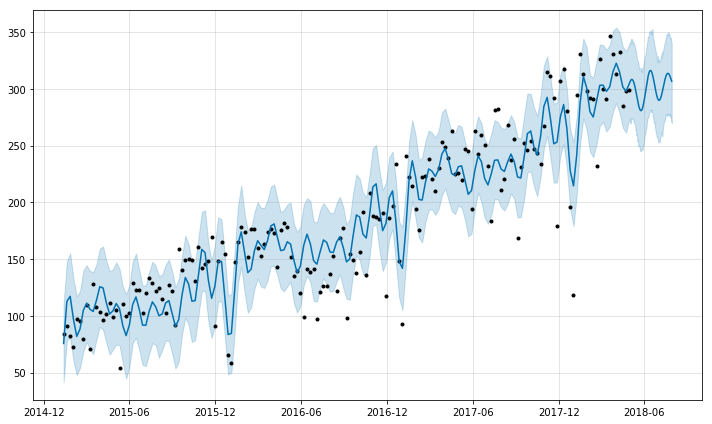

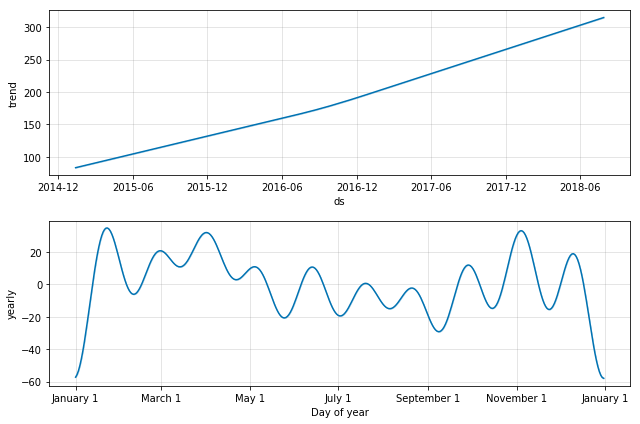

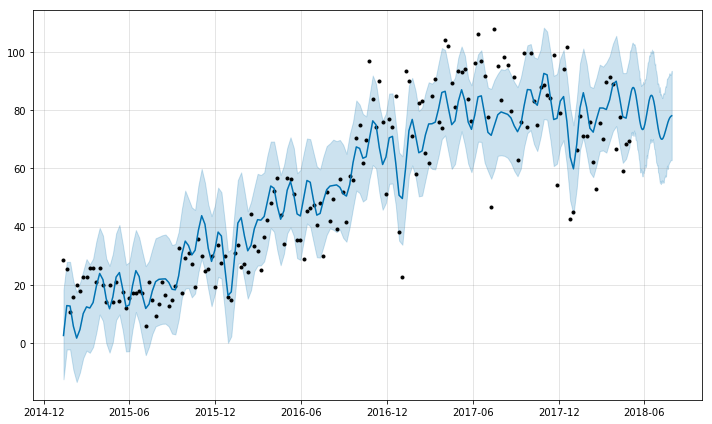

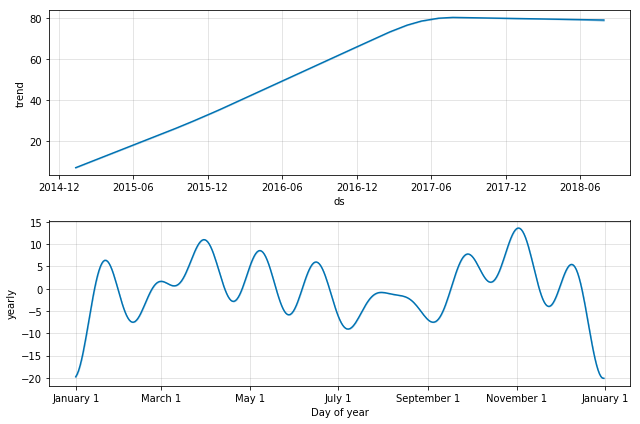

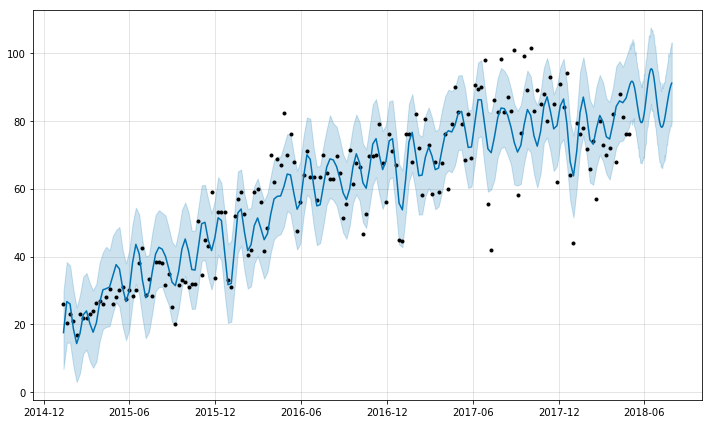

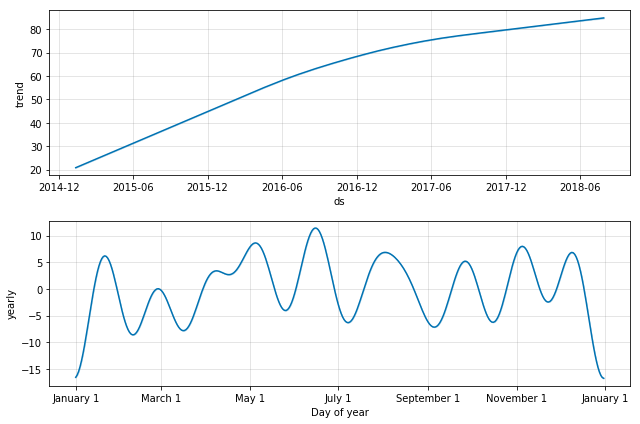

In [34]:
# Get forecast and plot for all 3 categories
for i in range(len(weekly_data)):
    model, forecast, predictions_df = get_prophet_forecast(df=weekly_data[i], df_name=df_names[i], df_cols=df_cols,\
                     date_hours_cols=date_hours_cols, pred_cols=pred_cols, periods=periods)
    plot_prophet_forecast(model, forecast)

In [35]:
# get MSE for forecasts with holidays w/ different windows included
holiday_windows = [holidays1, holidays2, holidays1_2, holidays2_1]
for i in range(len(weekly_data)):
    for h in holiday_windows:
        model, forecast, predictions_df = get_prophet_forecast_w_holidays(df=weekly_data[i], df_name=df_names[i], df_cols=df_cols,\
                     date_hours_cols=date_hours_cols, pred_cols=pred_cols, periods=periods, holidays=h)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for Doctors training set is 612.7269686476506
MSE for Doctors test set is 624.8643518347315


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for Doctors training set is 612.8394264436564
MSE for Doctors test set is 624.5225894427451


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for Doctors training set is 612.4728383023884
MSE for Doctors test set is 624.277462585503


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for Doctors training set is 612.4728383023884
MSE for Doctors test set is 624.277462585503


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for RN/PAs training set is 112.23955930164259
MSE for RN/PAs test set is 159.90451997774102


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for RN/PAs training set is 109.75398798385547
MSE for RN/PAs test set is 152.82846066912057


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for RN/PAs training set is 110.35985527371457
MSE for RN/PAs test set is 155.82944268866143


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for RN/PAs training set is 110.35985527371457
MSE for RN/PAs test set is 155.82944268866143


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for therapists training set is 73.47000001975812
MSE for therapists test set is 113.10802470069221


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for therapists training set is 73.04921138680379
MSE for therapists test set is 112.75465678438268


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for therapists training set is 73.52049720645674
MSE for therapists test set is 113.12496215963084
MSE for therapists training set is 73.52049720645674
MSE for therapists test set is 113.12496215963084


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for Doctors training set is 612.4728383023884
MSE for Doctors test set is 624.277462585503


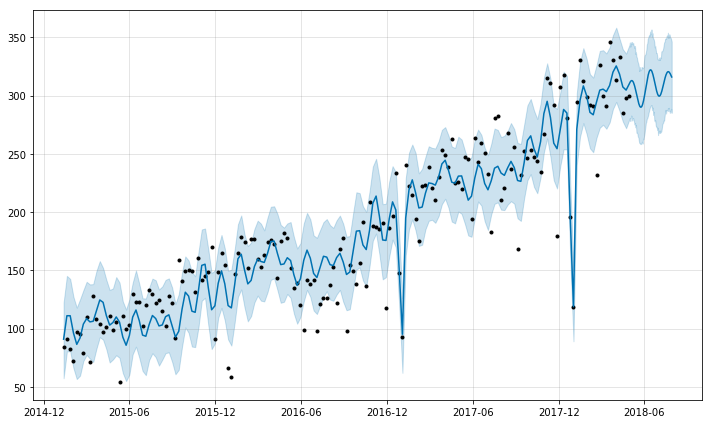

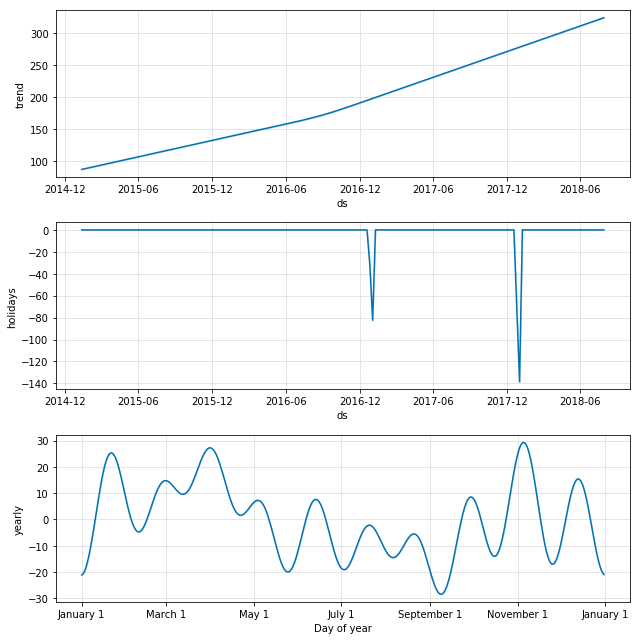

In [36]:
# Doctor's forecast + holidays
dr_model_h, dr_forecast_h, dr_pred_h = get_prophet_forecast_w_holidays(dr_df, 'Doctors', df_cols, date_hours_cols,\
                pred_cols, periods, holidays=h)
# plot forecast & decomposition w holidays
plot_prophet_forecast(dr_model_h, dr_forecast_h)

In [37]:
# add predicted number of providers column
dr_pred_h['Predicted_num_Providers'] = round(dr_pred_h['yhat'] / avg_dr_hours, 1)

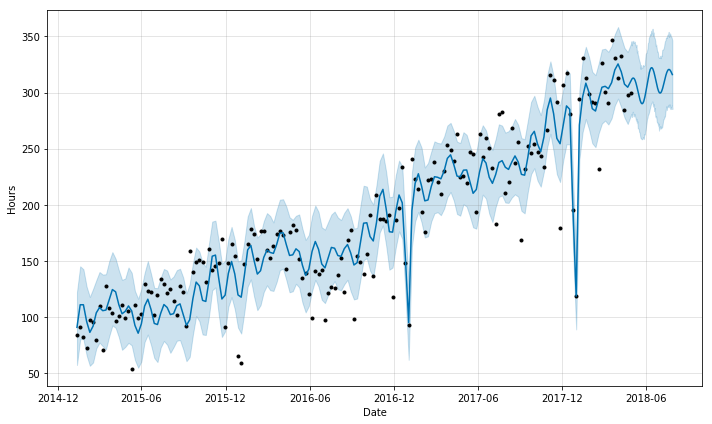

In [38]:
# fig = plot_prophet_forecast(dr_model_h, dr_forecast_h, xlabel='Date', ylabel='Hours')
dr_fig = dr_model_h.plot(dr_forecast_h, xlabel='Date', ylabel='Hours')
dr_fig.savefig('./images/dr_prophet_model.png')

In [39]:
dr_pred_h

,ds,y,yhat,yhat_lower,yhat_upper,Predicted_num_Providers
0,2015-01-12,84.25,90.843720,57.300694,122.283347,4.6
1,2015-01-19,91.25,110.981602,80.262351,145.225253,5.7
2,2015-01-26,82.00,110.974794,80.473112,142.600182,5.6
3,2015-02-02,72.25,96.144583,65.903999,127.145416,4.9
4,2015-02-09,97.25,86.388901,56.596672,117.899710,4.4
5,2015-02-16,95.25,91.922298,59.536871,125.043425,4.7
6,2015-02-23,79.25,103.796022,72.047557,132.821669,5.3
7,2015-03-02,109.50,108.512450,77.298641,140.138844,5.5
8,2015-03-09,71.00,105.698009,74.108387,137.885977,5.4
9,2015-03-16,128.00,106.247866,71.195345,138.129488,5.4


In [40]:
prophet_forecast_to_csv(dr_pred_h, 'doctors_prophet_holidays')

#### RN/PAs

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for RN/PAs training set is 110.35985527371457
MSE for RN/PAs test set is 155.82944268866143


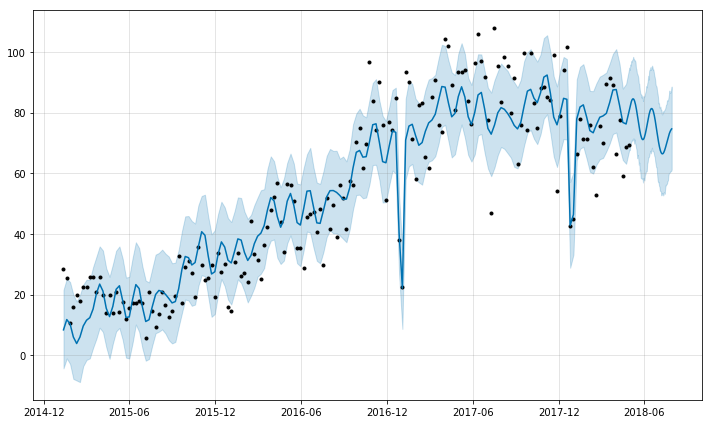

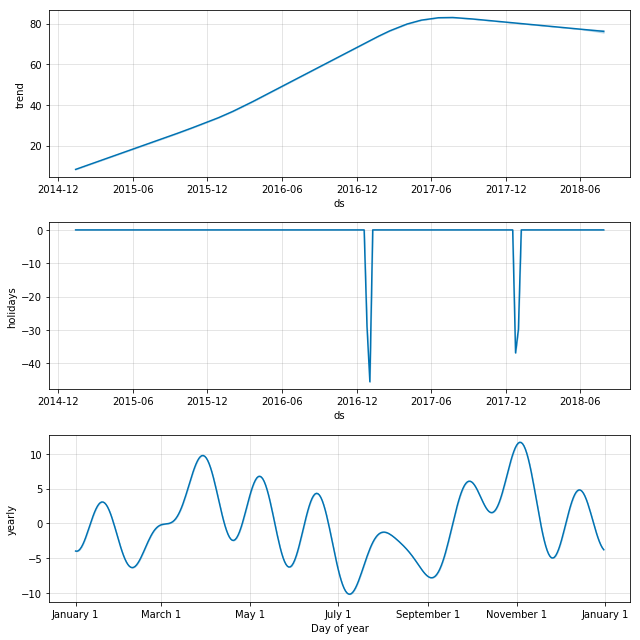

In [41]:
# RN/PA forecast + holidays
RNPA_model_h, RNPA_forecast_h, RNPA_pred_h = get_prophet_forecast_w_holidays(RNPA_df, 'RN/PAs', df_cols, date_hours_cols,\
                pred_cols, periods, holidays=h)
# plot forecast & decomposition w holidays
plot_prophet_forecast(RNPA_model_h, RNPA_forecast_h)

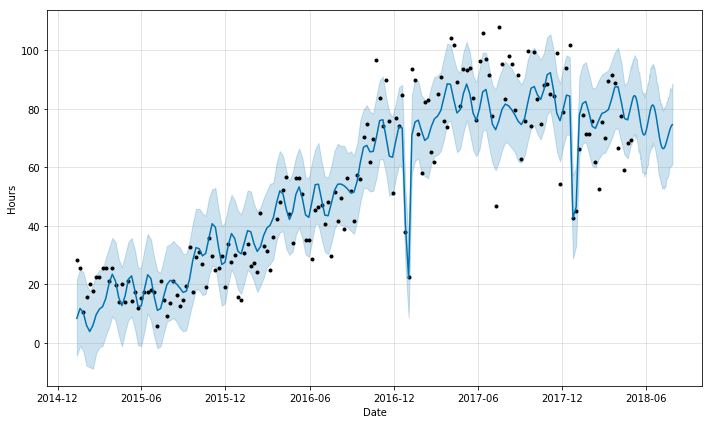

In [42]:
# fig = plot_prophet_forecast(dr_model_h, dr_forecast_h, xlabel='Date', ylabel='Hours')
RNPA_fig = RNPA_model_h.plot(RNPA_forecast_h, xlabel='Date', ylabel='Hours')
RNPA_fig.savefig('./images/RNPA_prophet_model.png')

In [43]:
avg_RNPA_hours = RNPA_df['Hours_per_Provider'].mean()

In [44]:
# add predicted number of providers column
RNPA_pred_h['Predicted_num_Providers'] = round(RNPA_pred_h['yhat'] / avg_RNPA_hours, 1)

In [45]:
prophet_forecast_to_csv(RNPA_pred_h, 'RNPA_prophet_holidays')

#### therapists

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for Therapists training set is 73.52049720645674
MSE for Therapists test set is 113.12496215963084


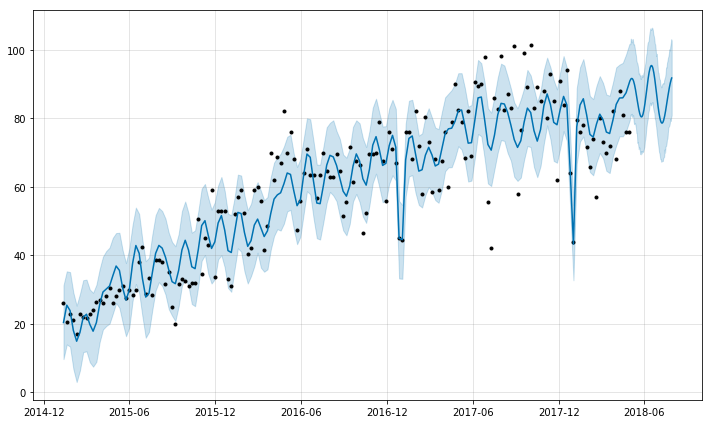

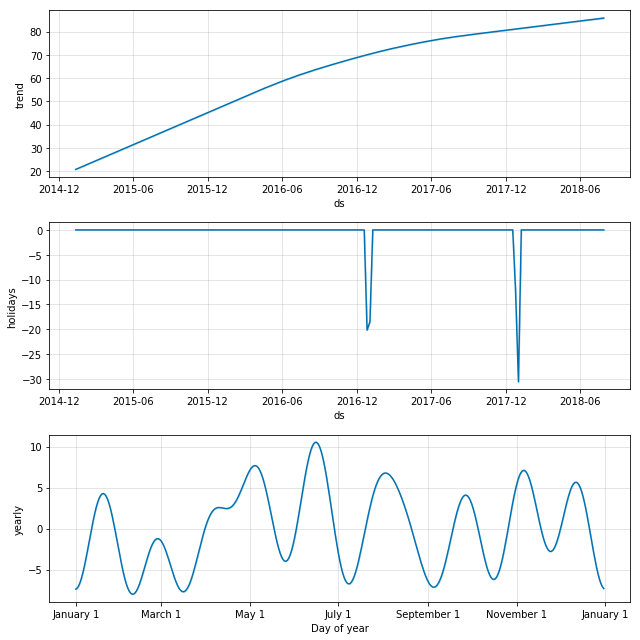

In [46]:
# Therapists forecast + holidays
ther_model_h, ther_forecast_h, ther_pred_h = get_prophet_forecast_w_holidays(ther_df, 'Therapists', df_cols, date_hours_cols,\
                pred_cols, periods, holidays=h)
# plot forecast & decomposition w holidays
plot_prophet_forecast(ther_model_h, ther_forecast_h)

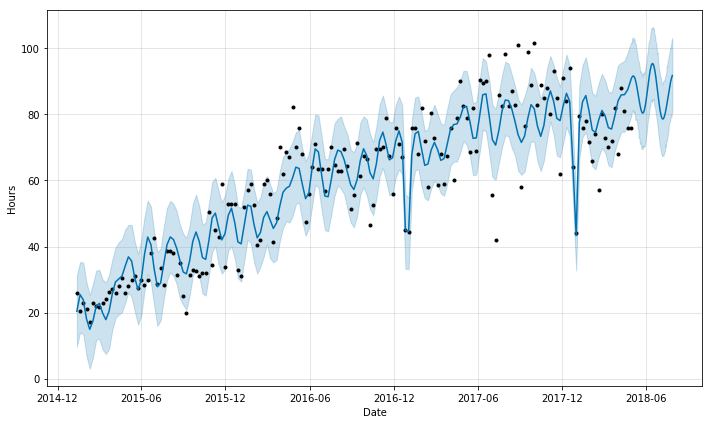

In [47]:
# fig = plot_prophet_forecast(dr_model_h, dr_forecast_h, xlabel='Date', ylabel='Hours')
ther_fig = ther_model_h.plot(ther_forecast_h, xlabel='Date', ylabel='Hours')
ther_fig.savefig('./images/ther_prophet_model.png')

In [48]:
avg_ther_hours = ther_df['Hours_per_Provider'].mean()

In [49]:
# add predicted number of providers column
ther_pred_h['Predicted_num_Providers'] = round(ther_pred_h['yhat'] / avg_ther_hours, 1)

In [50]:
prophet_forecast_to_csv(ther_pred_h, 'therapist_prophet_holidays')

In [51]:
ther_pred_h

,Date,True_Hours,Predicted_Hours,Lower_Limit,Upper_Limit,Predicted_num_Providers
0,2015-01-12,26.00,20.386854,9.699664,31.252104,1.8
1,2015-01-19,20.50,25.451826,13.984538,35.331820,2.3
2,2015-01-26,23.00,23.869373,13.356256,35.113272,2.2
3,2015-02-02,21.00,18.077701,6.848131,29.136614,1.6
4,2015-02-09,17.00,14.929042,3.004198,25.315874,1.4
5,2015-02-16,23.00,17.488911,6.387292,28.736059,1.6
6,2015-02-23,22.00,21.924385,11.757825,32.745101,2.0
7,2015-03-02,21.75,22.812385,11.972740,32.922329,2.1
8,2015-03-09,23.00,19.866565,8.797383,30.013914,1.8
9,2015-03-16,24.00,17.853461,7.501668,29.066456,1.6


#### get 12 week forecasts

In [52]:
forecasts = [dr_pred_h, RNPA_pred_h, ther_pred_h]

In [53]:
dr_3mo_forecast = dr_pred_h[174:186]
RNPA_3mo_forecast = RNPA_pred_h[174:186]
ther_3mo_forecast = ther_pred_h[174:186]

In [54]:
dr_3mo_forecast.columns

Index(['Date', 'True_Hours', 'Predicted_Hours', 'Lower_Limit', 'Upper_Limit',
       'Predicted_num_Providers'],
      dtype='object')

In [55]:
# round predicted hours column
dr_3mo_forecast['Predicted_Hours'] = round(dr_3mo_forecast['Predicted_Hours'])

In [56]:
dr_3mo_forecast

,Date,True_Hours,Predicted_Hours,Lower_Limit,Upper_Limit,Predicted_num_Providers
174,NaN,NaN,312.0,278.201708,342.045156,15.9
175,NaN,NaN,312.0,280.991493,345.607751,15.9
176,NaN,NaN,313.0,282.960111,344.741040,15.9
177,NaN,NaN,313.0,281.551077,346.145402,15.9
178,NaN,NaN,313.0,278.607209,344.144716,15.9
179,NaN,NaN,312.0,280.222573,344.318930,15.9
180,NaN,NaN,312.0,280.854564,345.401731,15.9
181,NaN,NaN,311.0,278.976195,343.008464,15.8
182,NaN,NaN,310.0,277.282935,342.713496,15.8
183,NaN,NaN,308.0,275.076973,340.766206,15.7


In [57]:
dr_3mo_forecast =  dr_3mo_forecast[['Predicted_Hours', 'Predicted_num_Providers']]
dr_3mo_forecast.rename_axis('Week')

,Predicted_Hours,Predicted_num_Providers
Week,,
174,312.0,15.9
175,312.0,15.9
176,313.0,15.9
177,313.0,15.9
178,313.0,15.9
179,312.0,15.9
180,312.0,15.9
181,311.0,15.8
182,310.0,15.8


In [58]:
# save df to image
dr_3mo_forecast.to_csv('./data/dr_12_week_prophet_forecast.csv')

#### get doctors 8-16 week forecast

In [59]:
dr_8_to_16_wk_prophet = dr_pred_h[184:193]

In [60]:
dr_8_to_16_wk_prophet

,Date,True_Hours,Predicted_Hours,Lower_Limit,Upper_Limit,Predicted_num_Providers
184,NaN,NaN,306.912697,276.590240,342.550042,15.6
185,NaN,NaN,305.228517,272.726607,335.699173,15.5
186,NaN,NaN,303.433453,274.581491,337.425529,15.4
187,NaN,NaN,301.573927,268.149077,333.633403,15.4
188,NaN,NaN,299.699726,268.173498,332.587592,15.3
189,NaN,NaN,297.862556,267.391920,330.182769,15.2
190,NaN,NaN,296.114541,264.737226,328.554626,15.1
191,NaN,NaN,294.506675,264.312469,327.407060,15.0
192,NaN,NaN,293.087308,261.320934,325.152541,14.9


In [61]:
# reset index to forecast week number
dr_8_to_16_wk_prophet = dr_8_to_16_wk_prophet.reset_index()

In [62]:
dr_8_to_16_wk_prophet.index = dr_8_to_16_wk_prophet.index+8

In [66]:
# round up hours column
dr_8_to_16_wk_prophet['Predicted_Hours'] = round(dr_8_to_16_wk_prophet['Predicted_Hours'],1)

In [67]:
dr_8_to_16_wk_prophet =  dr_8_to_16_wk_prophet[['Predicted_Hours', 'Predicted_num_Providers']]
dr_8_to_16_wk_prophet.rename_axis('Week')

,Predicted_Hours,Predicted_num_Providers
Week,,
8,306.9,15.6
9,305.2,15.5
10,303.4,15.4
11,301.6,15.4
12,299.7,15.3
13,297.9,15.2
14,296.1,15.1
15,294.5,15.0
16,293.1,14.9


In [68]:
# save df to image
dr_8_to_16_wk_prophet.to_csv('./data/dr_8_to_16_wk_prophet.csv')

#### save doctors predictions as images for presentation

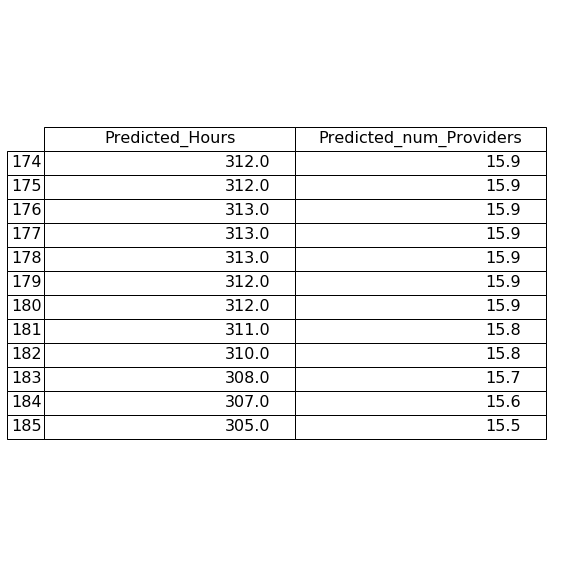

In [72]:
from pandas.tools.plotting import table
fig, ax = plt.subplots(figsize=(10,10)) # set size frame
ax.xaxis.set_visible(False)  # hide axes
ax.yaxis.set_visible(False)  
ax.set_frame_on(False)  
tabla = table(ax, dr_3mo_forecast, loc='center', colWidths=[0.3]*len(dr_3mo_forecast.columns))
tabla.auto_set_font_size(False) 
tabla.set_fontsize(16)
tabla.scale(1.5, 2) 
plt.savefig('./images/dr_12wk_Prophet_forecast.png', transparent=True)

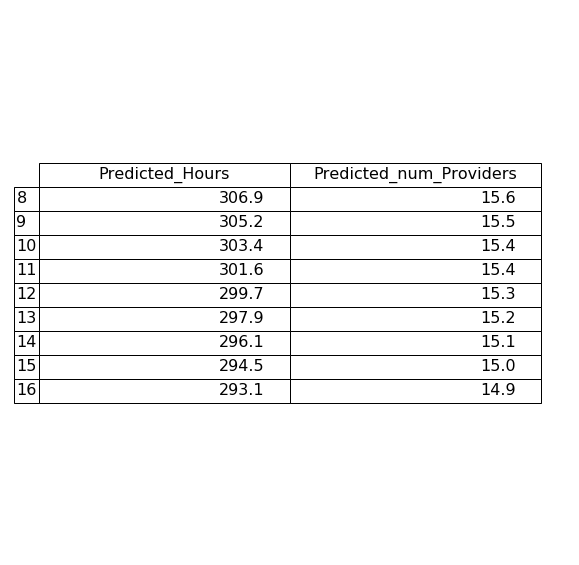

In [73]:
from pandas.tools.plotting import table
fig, ax = plt.subplots(figsize=(10,10)) # set size frame
ax.xaxis.set_visible(False)  # hide axes
ax.yaxis.set_visible(False)  
ax.set_frame_on(False)  
tabla = table(ax, dr_8_to_16_wk_prophet, loc='center', colWidths=[0.3]*len(dr_8_to_16_wk_prophet.columns))
tabla.auto_set_font_size(False) 
tabla.set_fontsize(16)
tabla.scale(1.5, 2) 
plt.savefig('./images/dr_8_to_16_wk_prophet.png', transparent=True)

#### Next Steps: 
##### add regressor for adding additional variable: number of providers

In [71]:
# Potential next steps: add exogenous variable - number of providers to each model
# help(Prophet.add_regressor)